In [1]:
import urllib.request
import requests
import pandas as pd
import seaborn as sns
import geopandas as gpd
import json
from matplotlib import pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



In [2]:
MAIRIES_FILE = 'data/mairies-martinique.geojson'
COMMUNES_FILES = 'data/communes-martinique.geojson'
INSEE_URL = 'https://www.insee.fr/fr/statistiques/fichier/3698339/base-pop-historiques-1876-2019.xlsx'
INSEE_LOCAL_FILE = 'output-tmp/insee.xlsx'

force_reload = False
os.makedirs('output-tmp/', exist_ok=True)

In [3]:
#get data

# get communes contour
urllib.request.urlretrieve('https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions/martinique/communes-martinique.geojson', COMMUNES_FILES)

# https://www.insee.fr/fr/statistiques/3698339
urllib.request.urlretrieve(INSEE_URL, INSEE_LOCAL_FILE)
df = pd.read_excel(INSEE_LOCAL_FILE, skiprows=5)
df_mq = df.loc[df.DEP == '972'].dropna(axis=1).copy()

# get mairie geolocation
if force_reload or not os.path.exists(MAIRIES_FILE):
    mairies = {
        "type": "FeatureCollection",
        "features": []
    }
    for codgeo in df_mq['CODGEO'].values:
        # see URL builder in https://api.gouv.fr/documentation/api-geo
        r = requests.get(f'https://geo.api.gouv.fr/communes/{codgeo}?fields=mairie&format=json')
        point = {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": r.json()["mairie"]["coordinates"]
                },
                "properties": {
                    "codgeo": codgeo
                }
            }
        mairies["features"].append(point)
    with open(MAIRIES_FILE, 'w') as o:
        o.write(json.dumps(mairies))

In [4]:
df_mq = df.loc[df.DEP == '972'].dropna(axis=1).copy()
df_mq.columns = list(df_mq.columns[:4]) + [f'20{c[-2:]}' if int(c[-2:]) < 20 else f'19{c[-2:]}' for c in  df_mq.columns[4:]]
base_100 = '1954'
df_mq_base100 = df_mq.copy()
df_mq_base100.loc[:, df_mq_base100.columns[4:]] = 100 * df_mq_base100.loc[:, df_mq_base100.columns[4:]].div(df_mq_base100[base_100], axis=0)
df_mq_base100 = df_mq_base100.melt(id_vars=list(df_mq_base100.columns[:4]), var_name='year', value_name='population').sort_values(by=['LIBGEO', 'year'])

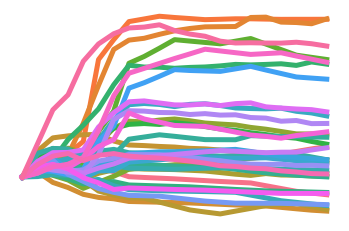

In [5]:
ax = sns.lineplot(data=df_mq_base100, x='year', y='population', hue='LIBGEO', linewidth=5)
ax.axis('off')
ax.get_legend().remove()

In [6]:
ymin, ymax = df_mq_base100['population'].min(),  df_mq_base100['population'].max()
# we could do it in memory, but let's see how it goes
for codgeo in df_mq['CODGEO'].values:
    ax = sns.lineplot(data=df_mq_base100.loc[df_mq_base100.CODGEO==codgeo], x='year', y='population', hue='LIBGEO', linewidth=10)
    plt.ylim(ymin, ymax)
    ax.axis('off')
    ax.get_legend().remove()
    plt.savefig(f'output-tmp/2022-11-02-{codgeo}.png', bbox_inches='tight', transparent=True)
    plt.clf()


<Figure size 432x288 with 0 Axes>

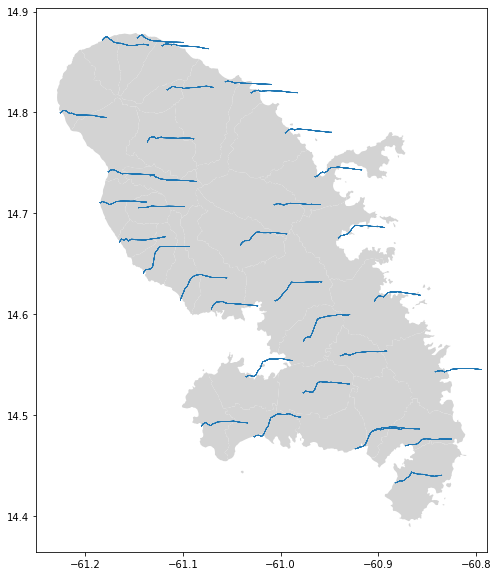

In [8]:
gdf_mq = gpd.read_file('data/communes-martinique.geojson')

gdf_mairies = gpd.read_file(MAIRIES_FILE, color="red")
ax = gdf_mq.plot(legend=True, figsize=(10,10), color="lightgrey")

def getImage(path):
    return OffsetImage(plt.imread(path, format="png"), zoom=0.15)

for i, row in gdf_mairies.iterrows():
    codgeo = row['codgeo']
    x0, y0 = row['geometry'].x + 0.022, row['geometry'].y + 0.008
    path = f'output-tmp/2022-11-02-{codgeo}.png'
    
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

plt.savefig('output/2022-11-02.png', bbox_inches='tight', transparent=True)

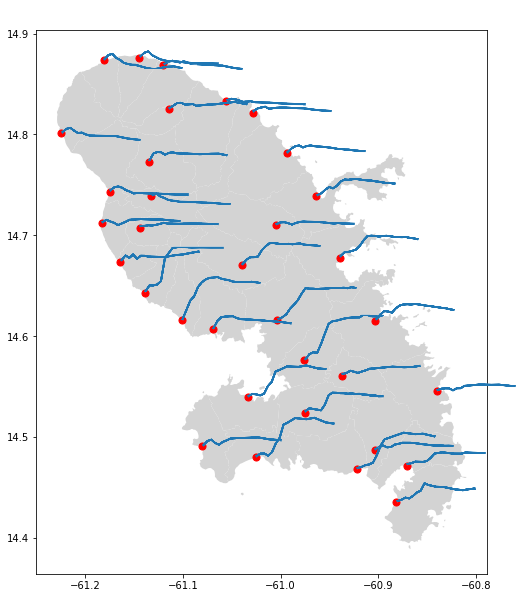

In [9]:
gdf_mq = gpd.read_file('data/communes-martinique.geojson')

ax = gdf_mq.plot(legend=True, figsize=(10,10), color="lightgrey")

gdf_mairies.plot(ax=ax, marker='o', color='red', markersize=50)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path, format="png"), zoom=0.25)

for i, row in gdf_mairies.iterrows():
    codgeo = row['codgeo']
    x0, y0 = row['geometry'].x + 0.04, row['geometry'].y + 0.018
    path = f'output-tmp/2022-11-02-{codgeo}.png'
    
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)